<a href="https://colab.research.google.com/github/sucharitaatha/DataScience/blob/master/Forex_pred_autoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
data = pd.read_excel('/content/gdrive/My Drive/Forex_with_News_data.xlsx', sheet_name="MarketData")

In [4]:
data.head()

,Date,"EUR/USD(Open, Ask)","EUR/USD(High, Ask)","EUR/USD(Low, Ask)","EUR/USD(Close, Ask)","EUR/USD(Open, Bid)","EUR/USD(High, Bid)","EUR/USD(Low, Bid)","EUR/USD(Close, Bid)",Difference in Close Bid in 4 hours,Class A,Class B,Class C,Class D,Group name based on Class,MAX of difference(i.e. J),MIN of difference(i.e. J),Class,Bottom Value,Top Value
0,2012-09-28 05:00:00,1.29472,1.29608,1.29356,1.29399,1.29447,1.29587,1.29332,1.29374,0.00132,NaN,NaN,C,NaN,C,1.4857,-0.03139,A,1,upwards
1,2012-09-28 03:00:00,1.29262,1.29486,1.29230,1.29472,1.29242,1.29463,1.29205,1.29447,0.00124,NaN,NaN,C,NaN,C,NaN,NaN,B,0.5,1
2,2012-09-28 01:00:00,1.29350,1.29425,1.29255,1.29262,1.29323,1.29401,1.29232,1.29242,-0.00113,NaN,NaN,NaN,D,D,NaN,NaN,C,0,0.5
3,2012-09-27 23:00:00,1.29381,1.29429,1.29303,1.29350,1.29355,1.29402,1.29278,1.29323,0.00144,NaN,NaN,C,NaN,C,NaN,NaN,D,downwards,0
4,2012-09-27 21:00:00,1.29207,1.29441,1.29099,1.29381,1.29179,1.29414,1.29071,1.29355,0.00262,NaN,NaN,C,NaN,C,NaN,NaN,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15093 entries, 0 to 15092
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Date                                15093 non-null  datetime64[ns]
 1   EUR/USD(Open, Ask)                  15093 non-null  float64       
 2   EUR/USD(High, Ask)                  15093 non-null  float64       
 3   EUR/USD(Low, Ask)                   15093 non-null  float64       
 4   EUR/USD(Close, Ask)                 15093 non-null  float64       
 5   EUR/USD(Open, Bid)                  15093 non-null  float64       
 6   EUR/USD(High, Bid)                  15093 non-null  float64       
 7   EUR/USD(Low, Bid)                   15093 non-null  float64       
 8   EUR/USD(Close, Bid)                 15093 non-null  float64       
 9   Difference in Close Bid in 4 hours  15093 non-null  float64       
 10  Class A               

In [6]:
data = data.set_index('Date')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15093 entries, 2012-09-28 05:00:00 to 2007-11-22 17:00:00
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   EUR/USD(Open, Ask)                  15093 non-null  float64
 1   EUR/USD(High, Ask)                  15093 non-null  float64
 2   EUR/USD(Low, Ask)                   15093 non-null  float64
 3   EUR/USD(Close, Ask)                 15093 non-null  float64
 4   EUR/USD(Open, Bid)                  15093 non-null  float64
 5   EUR/USD(High, Bid)                  15093 non-null  float64
 6   EUR/USD(Low, Bid)                   15093 non-null  float64
 7   EUR/USD(Close, Bid)                 15093 non-null  float64
 8   Difference in Close Bid in 4 hours  15093 non-null  float64
 9   Class A                             2 non-null      object 
 10  Class B                             0 non-null      float64
 11  Class 

In [8]:
# Reverse the order 
data = pd.DataFrame(data = data.iloc[::-1])

In [9]:
data = pd.DataFrame(data = data["EUR/USD(Close, Bid)"])

In [10]:
data.rename(columns = {'EUR/USD(Close, Bid)':'Close_Bid'}, inplace = True) 

In [11]:
data.head()

,Close_Bid
Date,
2007-11-22 17:00:00,1.4845
2007-11-22 19:00:00,1.4857
2007-11-22 21:00:00,1.4942
2007-11-22 23:00:00,1.4921
2007-11-23 01:00:00,1.4906


In [12]:
data_hrly = data.resample("2H").mean() #hourly resampling

In [13]:
data_hrly.head()

,Close_Bid
Date,
2007-11-22 16:00:00,1.4845
2007-11-22 18:00:00,1.4857
2007-11-22 20:00:00,1.4942
2007-11-22 22:00:00,1.4921
2007-11-23 00:00:00,1.4906


#### Time Series Decomposition & Statistical Tests

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Close_Bid'] = df['Close_Bid'].interpolate()
    print(df.head())
    print(df.isnull().sum())
    
fill_missing(data_hrly)

                     Close_Bid
Date                          
2007-11-22 16:00:00     1.4845
2007-11-22 18:00:00     1.4857
2007-11-22 20:00:00     1.4942
2007-11-22 22:00:00     1.4921
2007-11-23 00:00:00     1.4906
Close_Bid    0
dtype: int64


In [16]:
plt.figure(figsize=(15,12))
series = data_hrly.Close_Bid
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

TypeError: ignored

<Figure size 1080x864 with 0 Axes>

In [17]:
# Renaming the column names accroding to Prophet's requirements

data_hrly_fb = data_hrly.reset_index()[['Date','Close_Bid']].rename({'Date':'ds','Close_Bid':'y'}, axis=1)
data_hrly_fb.head()

,ds,y
0,2007-11-22 16:00:00,1.4845
1,2007-11-22 18:00:00,1.4857
2,2007-11-22 20:00:00,1.4942
3,2007-11-22 22:00:00,1.4921
4,2007-11-23 00:00:00,1.4906


In [18]:

split_date = "2012-01-01 21:00:00"
train_filt = data_hrly_fb['ds'] <= split_date
test_filt = data_hrly_fb['ds'] > split_date

train_fb = data_hrly_fb[train_filt]
test_fb = data_hrly_fb[test_filt]

print("train data shape :", train_fb.shape[0] / data_hrly_fb.shape[0] * 100)
print("test data shape :", test_fb.shape[0] / data_hrly_fb.shape[0] * 100)

train data shape : 84.74058046004045
test data shape : 15.259419539959545


In [19]:
pip install auto_ts

     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 1.5MB 6.0MB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
     |████████████████████████████████| 942kB 39.2MB/s 
     |████████████████████████████████| 2.1MB 60.0MB/s 
     |████████████████████████████████| 112kB 62.4MB/s 
ERROR: pmdarima 1.8.0 has requirement statsmodels!=0.12.0,>=0.11, but you'll have statsmodels 0.10.2 which is incompatible.
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [20]:
!pip install tscv

In [21]:
from auto_ts import auto_timeseries as ATS

Imported auto_timeseries version:0.0.36. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [23]:
test_length = 2336
automl_model = ATS(
    score_type='rmse',
    forecast_period=test_length, time_interval='D',
    model_type='best', verbose=0
)

In [24]:
ts_column = 'ds'
target = 'y'
sep = ','

In [25]:
train_fb.shape

(18015, 2)

In [26]:
train_fb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18015 entries, 0 to 18014
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      18015 non-null  datetime64[ns]
 1   y       18015 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 422.2 KB


Start of Fit.....
    Target variable given as = y
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: ds sep: , target: y
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (18015, 1)
No time series plot since verbose = 0. Continuing
Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 6335 Test Shape: 2336
    Root Mean Squared Error predictions vs actuals = 0.50
    Std Deviation of actuals = 0.04
    Normalized RMSE = 1206%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 8671 Test Shape: 2336
    Root Mean Squared Error predictions vs actuals = 1.20
   

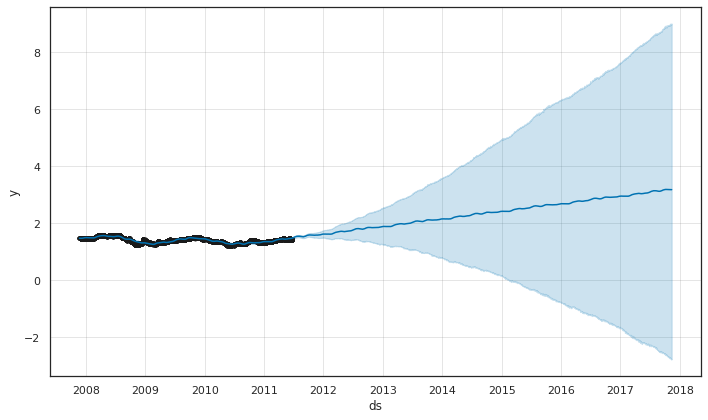

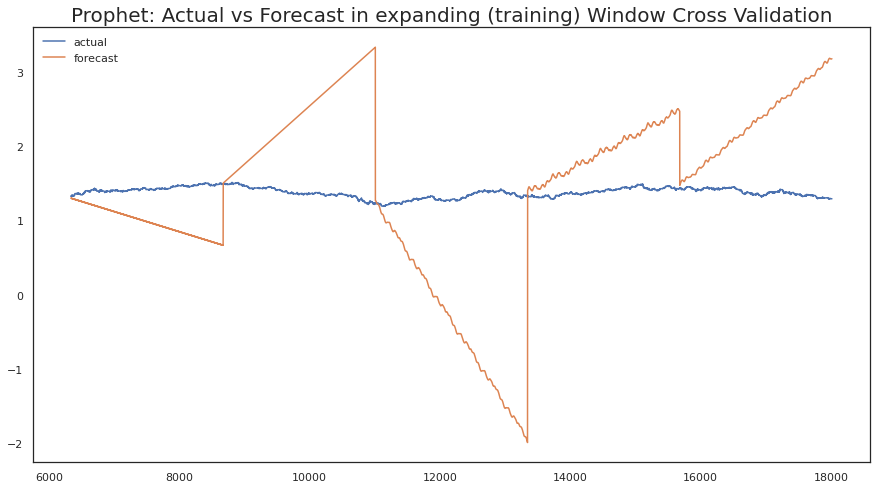

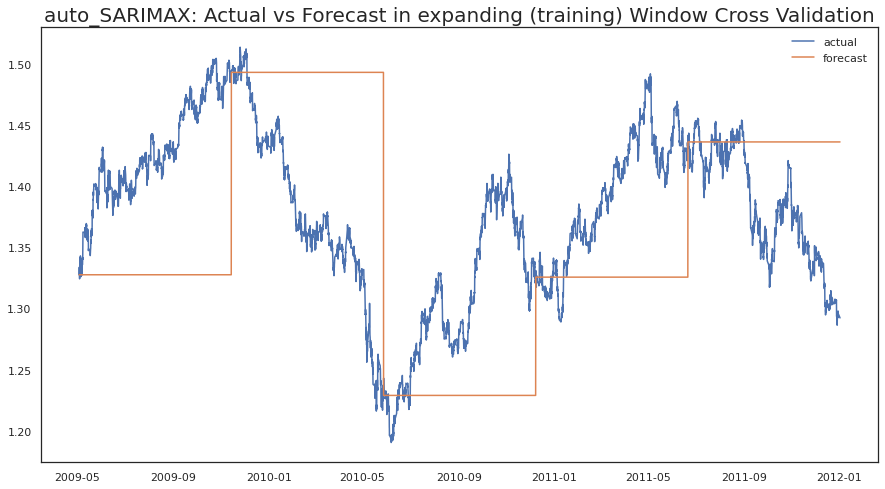

In [27]:
automl_model.fit(
    traindata=train_fb,
    ts_column=ts_column,
    target=target,
    cv=5,
    sep=',')

In [28]:
automl_model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,0.098641
0,Prophet,1.061839
2,ML,inf


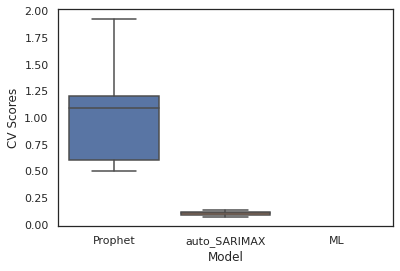

In [29]:
automl_model.plot_cv_scores()

In [30]:
# There is a Bug with Prophet folds: https://github.com/AutoViML/Auto_TS/issues/25
automl_model.get_cv_scores()

,Model,CV Scores
0,Prophet,0.497098
1,Prophet,1.195654
2,Prophet,1.923141
3,Prophet,0.604239
4,Prophet,1.089060
5,auto_SARIMAX,0.109115
6,auto_SARIMAX,0.131369
7,auto_SARIMAX,0.098924
8,auto_SARIMAX,0.083302
9,auto_SARIMAX,0.070495


In [31]:
results_dict = automl_model.get_ml_dict()
results_dict['Prophet']['forecast']

array([1.3012001 , 1.29863399, 1.30085946, ..., 3.17777805, 3.17777797,
       3.17845981])

In [32]:
results_dict['auto_SARIMAX']['forecast']

[array([1.3276592, 1.3276592, 1.3276592, ..., 1.3276592, 1.3276592,
        1.3276592]),
 array([1.4929872, 1.4929872, 1.4929872, ..., 1.4929872, 1.4929872,
        1.4929872]),
 array([1.22911506, 1.22911398, 1.22911401, ..., 1.22911401, 1.22911401,
        1.22911401]),
 array([1.32572, 1.32572, 1.32572, ..., 1.32572, 1.32572, 1.32572]),
 array([1.43616, 1.43616, 1.43616, ..., 1.43616, 1.43616, 1.43616])]

In [33]:
# Forecast Results
# Using Best Model
future_predictions = automl_model.predict(
    testdata=test_length
)  
future_predictions

y,yhat,mean_se,mean_ci_lower,mean_ci_upper
2012-01-01 22:00:00,1.292416,0.002569,1.287380,1.297452
2012-01-02 00:00:00,1.292402,0.003634,1.285281,1.299524
2012-01-02 02:00:00,1.292389,0.004450,1.283666,1.301111
2012-01-02 04:00:00,1.292375,0.005139,1.282303,1.302447
2012-01-02 06:00:00,1.292361,0.005745,1.281101,1.303622
...,...,...,...,...
2012-07-14 04:00:00,1.259402,0.124076,1.016217,1.502586
2012-07-14 06:00:00,1.259387,0.124103,1.016150,1.502624
2012-07-14 08:00:00,1.259372,0.124129,1.016084,1.502661
2012-07-14 10:00:00,1.259358,0.124156,1.016017,1.502699


In [34]:
# Using specific model
future_predictions = automl_model.predict(
    testdata=test_length,
    model='auto_SARIMAX'
)
future_predictions

y,yhat,mean_se,mean_ci_lower,mean_ci_upper
2012-01-01 22:00:00,1.292416,0.002569,1.287380,1.297452
2012-01-02 00:00:00,1.292402,0.003634,1.285281,1.299524
2012-01-02 02:00:00,1.292389,0.004450,1.283666,1.301111
2012-01-02 04:00:00,1.292375,0.005139,1.282303,1.302447
2012-01-02 06:00:00,1.292361,0.005745,1.281101,1.303622
...,...,...,...,...
2012-07-14 04:00:00,1.259402,0.124076,1.016217,1.502586
2012-07-14 06:00:00,1.259387,0.124103,1.016150,1.502624
2012-07-14 08:00:00,1.259372,0.124129,1.016084,1.502661
2012-07-14 10:00:00,1.259358,0.124156,1.016017,1.502699


In [35]:
# Using specific model
future_predictions = automl_model.predict(
    testdata=test_length,
    model='Prophet',
    simple=False

)
future_predictions

Building Forecast dataframe. Forecast Period = 2336


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
18015,2012-01-02 20:00:00,1.336586,1.272085,1.359930,1.336586,1.336586,-0.020694,-0.020694,-0.020694,-0.000007,-0.000007,-0.000007,-0.000481,-0.000481,-0.000481,-0.020206,-0.020206,-0.020206,0.0,0.0,0.0,1.315892
18016,2012-01-03 20:00:00,1.336248,1.268595,1.359244,1.336248,1.336248,-0.020700,-0.020700,-0.020700,-0.000007,-0.000007,-0.000007,-0.000396,-0.000396,-0.000396,-0.020297,-0.020297,-0.020297,0.0,0.0,0.0,1.315549
18017,2012-01-04 20:00:00,1.335911,1.270542,1.362651,1.335911,1.335911,-0.020029,-0.020029,-0.020029,-0.000007,-0.000007,-0.000007,0.000424,0.000424,0.000424,-0.020447,-0.020447,-0.020447,0.0,0.0,0.0,1.315882
18018,2012-01-05 20:00:00,1.335574,1.269770,1.358550,1.335574,1.335574,-0.020365,-0.020365,-0.020365,-0.000007,-0.000007,-0.000007,0.000293,0.000293,0.000293,-0.020651,-0.020651,-0.020651,0.0,0.0,0.0,1.315209
18019,2012-01-06 20:00:00,1.335236,1.273046,1.359973,1.335236,1.335236,-0.021079,-0.021079,-0.021079,-0.000007,-0.000007,-0.000007,-0.000165,-0.000165,-0.000165,-0.020907,-0.020907,-0.020907,0.0,0.0,0.0,1.314157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20346,2018-05-21 20:00:00,0.550268,-5.982994,7.341964,-5.991799,7.360673,0.006223,0.006223,0.006223,-0.000007,-0.000007,-0.000007,-0.000481,-0.000481,-0.000481,0.006711,0.006711,0.006711,0.0,0.0,0.0,0.556492
20347,2018-05-22 20:00:00,0.549931,-6.060017,7.335959,-5.995795,7.363585,0.006869,0.006869,0.006869,-0.000007,-0.000007,-0.000007,-0.000396,-0.000396,-0.000396,0.007272,0.007272,0.007272,0.0,0.0,0.0,0.556800
20348,2018-05-23 20:00:00,0.549594,-5.980545,7.411056,-5.999791,7.366497,0.008292,0.008292,0.008292,-0.000007,-0.000007,-0.000007,0.000424,0.000424,0.000424,0.007875,0.007875,0.007875,0.0,0.0,0.0,0.557886
20349,2018-05-24 20:00:00,0.549256,-6.033825,7.400456,-6.003788,7.369409,0.008791,0.008791,0.008791,-0.000007,-0.000007,-0.000007,0.000293,0.000293,0.000293,0.008505,0.008505,0.008505,0.0,0.0,0.0,0.558048
